# Fire Station Exploratory Data Analysis with NFIRS data

1. Goal is to create a metric of reporting quality so that we can have confidence in the data reported by that particular fire department.
2. Since we're mainly interested in areas which actually have fires, I decided to only look at departments with at least 1 fire each year. That way we don't have determine if a year with 0 fires reported is a reporting error (they didn't send in their data that year), or if it was actually a year with 0 fires.
3. Then, the coefficient of variation was used to determine how dispersed the data was for a given year. A coefficient of variation threshold of 0.4 was set (anything below that coefficient of variation and with no zero-fire years was considered good quality data). 
    1. This by definition will exclude fire departments that have <b>legitimate</b> large changes in fires from year to year. However those could also be considered outliers.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

In [ ]:
import sys
module_abs_path = os.path.abspath('../utils/python_modules')
sys.path.append(module_abs_path)

from useful_functions import *

In [3]:
output_dir = '../Data/processed/'

# Data Import and Cleaning

## NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [4]:
nfirs_path = '../Data/Master Project Data/NFIRS Fire Incident Data.csv'

cols_to_use = ['state','fdid','city','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','geoid']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

/Users/kelson/anaconda3/envs/rcp2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Fix the tot_loss column which had incorrect data for 2015. Since tot_loss = prop_loss + cont_loss, it was easy enough to recalculate those values
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

In [6]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [7]:
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')
nfirs['10k_loss'] = np.where(nfirs['tot_loss']>=10000,'had_10k_loss','no_10k_loss')

In [8]:
nfirs['year'] = nfirs['inc_date'].dt.year

## Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [9]:
nfirs['geoid'].str.len().value_counts()

14    1866509
4       84132
Name: geoid, dtype: int64

In [10]:
nfirs['geoid'] = nfirs['geoid'].str[2:]

In [11]:
nfirs =  nfirs[  nfirs['geoid'].str.len() ==12 ]

In [12]:
# Create tract column
nfirs['tract'] = nfirs['geoid'].str[:11]

## SVI Data

In [13]:
svi2016_path = '../Data/Master Project Data/SVI Tract Data.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     dtype = svi_col_dtypes)


svi2016['FIPS'] = svi2016['FIPS'].str.zfill(11)

# Aggregate by Fire Department

Add fire department unique id's to the NFIRS dataframe and aggregate by fire dept unique ID

In [15]:
fire_depts = pd.read_csv('../Data/Master Project Data/Fire Station Location Data.csv')

In [16]:
fire_depts['st_fdid'] = fire_depts['STATE'] + fire_depts['FDID'].astype(str)
nfirs['st_fdid'] = nfirs['state'] + nfirs['fdid'].astype(str)

In [17]:
# join on st_fdid
nfirs = nfirs.merge(fire_depts[['st_fdid','Unique ID']].drop_duplicates(subset=['st_fdid']),how='left',on='st_fdid',validate='many_to_one')

In [18]:
nfirs

,geoid,fdid,inc_date,city,state,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,severe_fire,had_inj,had_death,10k_loss,year,tract,st_fdid,Unique ID
0,021100005001,11100,2009-01-03,JUNEAU,AK,0,0,20000,5000,25000,sev_fire,no_inj,no_death,had_10k_loss,2009,02110000500,AK11100,10487990.0
1,021100004002,11100,2009-03-23,JUNEAU,AK,0,0,0,0,0,not_sev_fire,no_inj,no_death,no_10k_loss,2009,02110000400,AK11100,10487990.0
2,020200027022,23100,2009-01-01,Anchorage,AK,0,0,50000,10000,60000,sev_fire,no_inj,no_death,had_10k_loss,2009,02020002702,AK23100,10487969.0
3,010730144091,112,2009-03-12,HOOVER,AL,0,0,3500,0,3500,not_sev_fire,no_inj,no_death,no_10k_loss,2009,01073014409,AL112,10501201.0
4,060133373006,7090,2009-12-24,Walnut Creek,CA,0,0,1500,500,2000,not_sev_fire,no_inj,no_death,no_10k_loss,2009,06013337300,CA7090,10507762.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866504,090091712003,6120,2013-05-23,MERIDEN,CT,0,0,60000,5000,65000,sev_fire,no_inj,no_death,had_10k_loss,2013,09009171200,CT6120,10494827.0
1866505,090091717001,6120,2013-05-25,MERIDEN,CT,0,0,1000,500,1500,not_sev_fire,no_inj,no_death,no_10k_loss,2013,09009171700,CT6120,10494827.0
1866506,090091714002,6120,2013-05-26,MERIDEN,CT,0,0,0,0,0,not_sev_fire,no_inj,no_death,no_10k_loss,2013,09009171400,CT6120,10494827.0
1866507,090091712003,6120,2013-05-30,MERIDEN,CT,0,0,2000,2000,4000,not_sev_fire,no_inj,no_death,no_10k_loss,2013,09009171200,CT6120,10494827.0


In [19]:
nfirs['Unique ID'].isnull().sum()

484912

## There were a huge number of rows in nfirs without a matching state & fdid in the fire_depts dataframe (~700,000)
So I decided to just look at the st_fdid from nfirs instead

In [22]:
# Zero-pad the fdid numbers to the correct length. The FDID manual suggests that this should be used
nfirs['fdid2'] = nfirs['fdid'].astype(str).str.zfill(5)
nfirs['st_fdid2'] = nfirs['state'] + nfirs['fdid2']

# Frequency table
nfirs_fdid = pd.crosstab(nfirs['st_fdid2'],[nfirs['year'],nfirs['severe_fire']])

# Add tot_fires columns
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_fdid[(year,'tot_fires')] = nfirs_fdid[(year,'not_sev_fire')] + nfirs_fdid[(year,'sev_fire')]
nfirs_fdid = nfirs_fdid[sorted(nfirs_fdid.columns)]

# column list to use
year_tot_fires_cols = [(year, 'tot_fires') for year in [2009,2010,2011,2012,2013,2014,2015,2016]]

In [23]:
nfirs_fdid[year_tot_fires_cols].sort_values((2009,'tot_fires'),ascending=False).head(10)

year,2009,2010,2011,2012,2013,2014,2015,2016
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires
st_fdid2,,,,,,,,
NY24001,20435,20665,17954,17442,19530,19667,19548,19868
ILCS931,3823,4209,4032,3855,3883,3711,3521,3366
MI08207,2920,3080,3244,3224,3511,3215,2833,1674
MA25035,2780,2814,2686,2708,2791,2829,2585,3201
CA19105,2233,2176,2112,1534,2041,1898,1769,1126
TN79553,1286,1604,1489,1117,981,1070,1229,863
MD25001,1272,1213,1182,991,890,1010,1048,1053
FL01032,1070,1136,1001,968,967,866,555,520


In [24]:
fraction_with_zeros = (nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1).sum() / nfirs_fdid.shape[0]
print('{:.3} of the fire department id’s have at least one year in which they reported 0 fires'.format(fraction_with_zeros))

0.726 of the fire department id’s have at least one year in which they reported 0 fires


## Fire Dept Data Issue - Lots of years with 0 fires reported

In [25]:
nfirs_fdid[year_tot_fires_cols][(nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1)].sort_values((2009,'tot_fires'),ascending=False).head(10)

year,2009,2010,2011,2012,2013,2014,2015,2016
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires
st_fdid2,,,,,,,,
GA06001,505,583,523,545,505,540,467,0
NY34051,483,452,0,410,494,443,444,495
CA07090,378,352,326,258,0,0,0,0
NJ09013,375,376,192,0,321,331,331,329
AL00201,320,316,371,194,0,307,187,0
NY15100,314,0,205,226,233,266,0,0
PA02231,304,226,4,0,0,357,233,0
IN49009,289,148,336,240,77,0,0,0


In [20]:
# Ok, now that I've got the fire data aggregated by fire department, even though it is very poor, perhaps I can glean some interesting information from it.
# Aside from just data quality issues.

In [26]:
nfirs_fdid['sum_tot_fires'] = nfirs_fdid[year_tot_fires_cols].sum(axis=1)

In [27]:
(nfirs_fdid[nfirs_fdid['sum_tot_fires'] > 1000][(nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1)]
 .sort_values('sum_tot_fires',ascending=False)[list(year_tot_fires_cols) + [('sum_tot_fires','')]].head(10))

<ipython-input-27-0ab0fd19a33e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (nfirs_fdid[nfirs_fdid['sum_tot_fires'] > 1000][(nfirs_fdid[year_tot_fires_cols] == 0).any(axis=1)]


year,2009,2010,2011,2012,2013,2014,2015,2016,sum_tot_fires
severe_fire,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,tot_fires,
st_fdid2,,,,,,,,,
PA51001,0,1898,1679,1862,2291,2256,1867,0,11853
CA19110,0,1293,1304,439,1037,1132,1195,984,7384
NY60061,0,0,0,703,736,754,765,844,3802
GA06001,505,583,523,545,505,540,467,0,3668
NY34051,483,452,0,410,494,443,444,495,3221
CA37140,0,587,582,207,363,512,289,398,2938
FL03051,0,595,503,511,579,520,144,0,2852
AL00102,75,620,609,0,193,172,583,475,2727


## Fraction of depts reporting 0 fires each year

In [28]:
# The number of fire departments reporting 0 total fires each year
no_fire_fdids = pd.DataFrame((nfirs_fdid[year_tot_fires_cols] == 0).sum())

no_fire_fdids = no_fire_fdids.reset_index().set_index('year').drop('severe_fire',axis=1)

no_fire_fdids.columns = ['depts_with_0_fires']

no_fire_fdids['fraction_with_0_fires'] = no_fire_fdids['depts_with_0_fires'] / nfirs_fdid.shape[0]

In [29]:
no_fire_fdids

,depts_with_0_fires,fraction_with_0_fires
year,,
2009,9821,0.390404
2010,9737,0.387065
2011,9499,0.377604
2012,9821,0.390404
2013,9991,0.397162
2014,9977,0.396605
2015,9717,0.386270
2016,8505,0.338090


Text(0.5, 1.0, 'Fraction of fire departments reporting 0 fires in a given year')

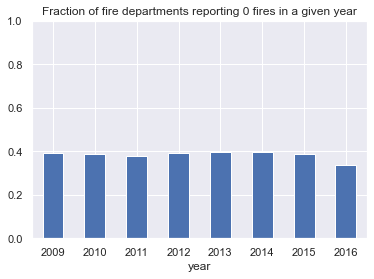

In [30]:
fig,ax = plt.subplots()
no_fire_fdids['fraction_with_0_fires'].plot.bar(ax=ax,rot=0)
ax.set_ylim((0,1))
ax.set_title('Fraction of fire departments reporting 0 fires in a given year')

In [32]:
# The fraction of fire departments which reported fewer than 10 fires during the whole time period. This suggests that a large 
# fraction of the fire departments are smaller & deal with a small amount of fires over time.
(nfirs_fdid['sum_tot_fires'] < 10).sum() / nfirs_fdid.shape[0]

0.4036412784226427

Text(0.5, 1.0, 'Histogram of total number of fires reported in NFIRS by a given fire department')

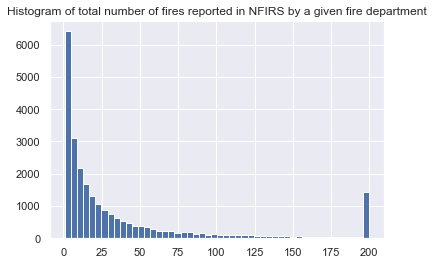

In [33]:
fig,ax = plt.subplots()
nfirs_fdid['sum_tot_fires'].clip(0,200).hist(bins = 50,ax=ax)
ax.set_title('Histogram of total number of fires reported in NFIRS by a given fire department')

# Finding reliable districts

In [34]:
from scipy import stats

In [35]:
df = nfirs_fdid.loc[:,(slice(2009,2016),'tot_fires')].copy()
df.columns = list(range(2009,2017))

df['zero_years'] = (df==0).sum(axis=1)
df['sum_tot_fires'] = df.loc[:,range(2009,2017)].sum(axis=1)
df['std'] = df[range(2009,2017)].std(axis=1)
df['variation'] = stats.variation(df[range(2009,2017)],axis=1)

df = df.reset_index()
df['state'] = df['st_fdid2'].str[:2]
df = df.set_index('st_fdid2')

### Calculate the Geometric Coefficient of Variation

This is analagous to the coefficient of variation, but is meant to be used with data which has a log-normal distribution (which our data on fires per fire station does). There wasn't a large difference between the results of the geometric coefficient of variation and the regular coefficient of variation, so the regular coefficient of variation was used below.

In [36]:
df['geometric_variation'] = df[range(2009,2017)].apply(np.log1p).std(axis=1).apply(lambda x: np.exp(x)-1)

### Total Fires per fire station histogram

AttributeError: 'Series' object has no attribute 'asint'

In [45]:
fig,ax = plot_log_hist(df['sum_tot_fires'].astype(int))
ax.set_title('Total Fires per Fire Station (over 8 years) Histogram')
ax.set_ylabel('Frequency')
a = ax.set_xlabel('Number of Fires per Fire Station')

TypeError: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

### Number of years with 0 fires histogram

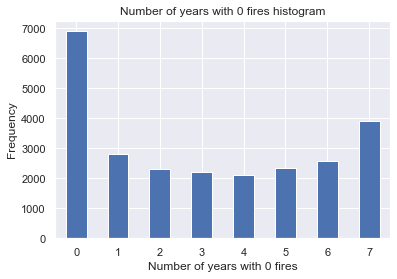

In [46]:
fig,ax = plt.subplots()
df['zero_years'].value_counts().sort_index().plot.bar(ax=ax)
plt.xticks(rotation=0)
ax.set_title('Number of years with 0 fires histogram')
ax.set_xlabel('Number of years with 0 fires')
a=ax.set_ylabel('Frequency')

### Coefficient of variation (fires per year) histogram

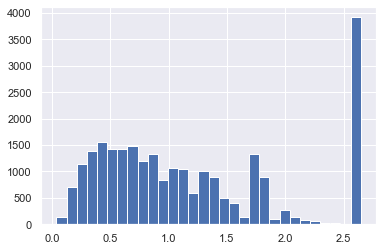

In [47]:
df['variation'].hist(bins=30)

### Coefficient of variation vs. number of 0 fire years

In [48]:
(df.groupby('zero_years')
 ['variation']
 .describe().round(2)
)

,count,mean,std,min,25%,50%,75%,max
zero_years,,,,,,,,
0,6899.0,0.41,0.18,0.04,0.28,0.39,0.51,2.07
1,2791.0,0.67,0.16,0.38,0.56,0.64,0.75,1.90
2,2320.0,0.84,0.17,0.58,0.72,0.81,0.92,2.23
3,2211.0,1.01,0.17,0.77,0.89,0.98,1.09,2.31
4,2099.0,1.21,0.18,1.00,1.11,1.17,1.29,2.24
5,2327.0,1.47,0.18,1.29,1.36,1.41,1.56,2.44
6,2590.0,1.85,0.15,1.73,1.73,1.78,1.86,2.60
7,3919.0,2.65,0.00,2.65,2.65,2.65,2.65,2.65


### Total fires vs number of zero years

In [49]:
(df.groupby('zero_years')
 ['sum_tot_fires']
 .describe().round(2)
)

,count,mean,std,min,25%,50%,75%,max
zero_years,,,,,,,,
0,6899.0,211.75,2003.22,10.0,39.0,69.0,143.0,155109.0
1,2791.0,62.54,223.88,7.0,18.0,27.0,46.0,7384.0
2,2320.0,41.26,267.16,6.0,12.0,18.0,29.0,11853.0
3,2211.0,26.41,108.88,5.0,9.0,12.0,20.0,3802.0
4,2099.0,14.75,42.10,4.0,6.0,8.0,13.0,1314.0
5,2327.0,9.49,20.31,3.0,4.0,6.0,9.0,473.0
6,2590.0,6.10,16.57,2.0,2.0,3.0,5.0,459.0
7,3919.0,2.07,4.65,1.0,1.0,1.0,2.0,166.0


### Metric of Fire Department Reporting Quality

1. Binary
    1. High quality/consistency. These are fire departments which have similar numbers of fires over time. These are also fire departments which don't have any 0 fire years. This will probably bias the model slightly, as rural areas with few fires will by definition not be given a high quality/consistency rating. 
    2. Not high quality. So we're just looking at departments where there is at least 1 fire each year. 
2. Since we're interested in doing fire alarm installations in areas with more fires, it makes sense to target areas with more fires on aggregate.

We'll somewhat arbitrarily set the coefficient of variation threshold

In [50]:
df[df['zero_years']==0]['variation'].describe()

count    6899.000000
mean        0.409362
std         0.178607
min         0.039636
25%         0.282843
50%         0.390326
75%         0.510672
max         2.068026
Name: variation, dtype: float64

In [51]:
mask = (df['zero_years']==0) & (df['variation'] < .4)
df[mask].sample(5)

,2009,2010,2011,2012,2013,2014,2015,2016,zero_years,sum_tot_fires,std,variation,state,geometric_variation
st_fdid2,,,,,,,,,,,,,,
MI04113,5,11,10,4,12,12,7,9,0,70,3.105295,0.331970,MI,0.437639
MA13085,6,11,21,10,18,16,16,10,0,108,5.014265,0.347438,MA,0.456340
GA02801,85,160,131,133,152,132,124,120,0,1037,22.544797,0.162690,GA,0.208284
FL05062,28,18,10,15,14,22,8,13,0,128,6.524678,0.381455,FL,0.461597
OK63012,14,15,13,12,12,15,16,19,0,116,2.329929,0.150307,OK,0.156574


In [52]:
# Binary quality indicator
df['station_data_quality'] = np.where(mask,1,0)

In [53]:
df.sample(5)

,2009,2010,2011,2012,2013,2014,2015,2016,zero_years,sum_tot_fires,std,variation,state,geometric_variation,station_data_quality
st_fdid2,,,,,,,,,,,,,,,
MD04005,4,2,2,1,3,0,1,3,1,16,1.309307,0.612372,MD,0.678484,0
LA62005,0,2,7,2,5,4,3,6,1,29,2.326094,0.600238,LA,0.944234,0
GA02512,4,1,6,1,0,0,9,1,2,22,3.284161,1.117110,GA,1.376438,0
MEE3530,5,7,2,2,2,0,1,4,1,23,2.295181,0.746764,ME,0.928012,0
VT08336,9,5,5,9,4,8,8,4,0,52,2.203893,0.317162,VT,0.355557,1


# Output Results

In [54]:
cols = df.columns
new_cols = ['station_data_quality'] + list(cols.drop(['state','station_data_quality']))
df = df[new_cols]

In [55]:
df.head()

,station_data_quality,2009,2010,2011,2012,2013,2014,2015,2016,zero_years,sum_tot_fires,std,variation,geometric_variation
st_fdid2,,,,,,,,,,,,,,
AK11100,1,30,31,33,42,29,33,27,31,0,256,4.503967,0.131659,0.135662
AK12100,0,0,2,4,6,3,2,4,0,2,21,2.065879,0.736173,1.076289
AK12150,0,0,0,1,0,0,0,0,0,7,1,0.353553,2.645751,0.277704
AK12200,1,3,2,2,2,3,4,3,4,0,23,0.834523,0.271522,0.240924
AK12220,0,0,0,0,0,0,0,0,1,7,1,0.353553,2.645751,0.277704


In [56]:
df.to_csv(output_dir + 'Fire_Station_Reporting_Quality.csv')